# Ground Station — Data Cleaning & Feature Engineering

In [8]:
from __future__ import annotations
from dataclasses import dataclass
from pathlib import Path
import numpy as np
import pandas as pd
import pvlib
import matplotlib.pyplot as plt

## Config

In [9]:
PRQ_IN   = Path("../data_interim/ground_features.parquet")
OUT_INT  = Path("../data_interim")
OUT_PROC = Path("../data_processed")
OUT_INT.mkdir(parents=True, exist_ok=True)
OUT_PROC.mkdir(parents=True, exist_ok=True)

In [10]:
FREQ        = "10min"
LAT, LON, ALT_M = 4.6043, -74.0659, 2624.0
DAY_WM2     = 50.0           # umbral “día” para k

# TARGET_BASE = "ghi_qc"  
H_LIST = [6, 18, 36]

## Data

In [11]:
df = pd.read_parquet(PRQ_IN).sort_index()

if df.index.tz is None:
    df.index = df.index.tz_localize("UTC")
else:
    df.index = df.index.tz_convert("UTC")

print("Date range:", df.index.min(), "→", df.index.max())
print("Columns:", len(df.columns))

Date range: 2023-09-01 05:00:00+00:00 → 2025-03-28 04:50:00+00:00
Columns: 65


In [12]:
df.head()

,Hr,p_hpa,wdir_deg,temp_c,wspd_ms,ghi_cs,hod_sin,hod_cos,doy_sin,doy_cos,...,y_ghi_h18,y_ghi_sg_h18,y_k_raw_h24,y_k_h24,y_ghi_h24,y_ghi_sg_h24,y_k_raw_h36,y_k_h36,y_ghi_h36,y_ghi_sg_h36
Timestamp,,,,,,,,,,,,,,,,,,,,,
2023-09-01 05:00:00+00:00,74.391998,745.236023,135.766006,12.505,1.950,0.0,0.0,1.0,-0.871706,-0.490029,...,0.0,0.0,NaN,10371.428711,0.000,0.010371,NaN,3.157978,13.117000,13.100971
2023-09-01 05:10:00+00:00,76.579002,745.085999,112.135002,12.032,2.514,0.0,0.0,1.0,-0.871706,-0.490029,...,0.0,0.0,NaN,29085.714844,0.038,0.029086,NaN,0.846947,21.969999,21.708057
2023-09-01 05:20:00+00:00,75.459999,744.940002,111.295998,12.337,2.126,0.0,0.0,1.0,-0.871706,-0.490029,...,0.0,0.0,NaN,28085.714844,0.031,0.028086,0.477264,0.477013,29.533001,29.517487
2023-09-01 05:30:00+00:00,77.004997,744.969971,102.699997,11.872,2.877,0.0,0.0,1.0,-0.871706,-0.490029,...,0.0,0.0,NaN,-9857.142578,0.000,-0.009857,0.344864,0.355321,36.602001,37.711830
2023-09-01 05:40:00+00:00,77.724998,745.020020,106.753998,11.756,3.159,0.0,0.0,1.0,-0.871706,-0.490029,...,0.0,0.0,NaN,63171.429688,0.000,0.063171,0.285757,0.265680,44.153999,41.051743


In [13]:
print("Date range:", df.index.min(), "→", df.index.max())
print("Columns:", len(df.columns))

Date range: 2023-09-01 05:00:00+00:00 → 2025-03-28 04:50:00+00:00
Columns: 65


## Multi-horizon export


=== Procesando horizonte H=6 (=> +60 min) ===
  Usando TARGET: y_ghi_h6
  Filas tras limpieza: 82560 | #Features: 45 | Target: y_ghi_h6
  Guardado splits para y_ghi_h6 → h6
    train: (57791, 46) → ../data_processed/ground_train_h6.parquet
    val  : (12385, 46) → ../data_processed/ground_val_h6.parquet
    test : (12384, 46) → ../data_processed/ground_test_h6.parquet

  Top 10 features correlacionadas con y_ghi_h6 (Spearman):
zenith                -0.857557
ghi_cs                 0.857459
ghi_qc_lag1            0.838078
ghi_qc_lag2            0.816877
ghi_qc_roll_mean_1h    0.810178
hod_cos               -0.802457
ghi_qc_lag3            0.795074
ghi_qc_roll_std_1h     0.759086
temp_c                 0.561917
temp_c_lag1            0.532584
Name: y_ghi_h6, dtype: float64


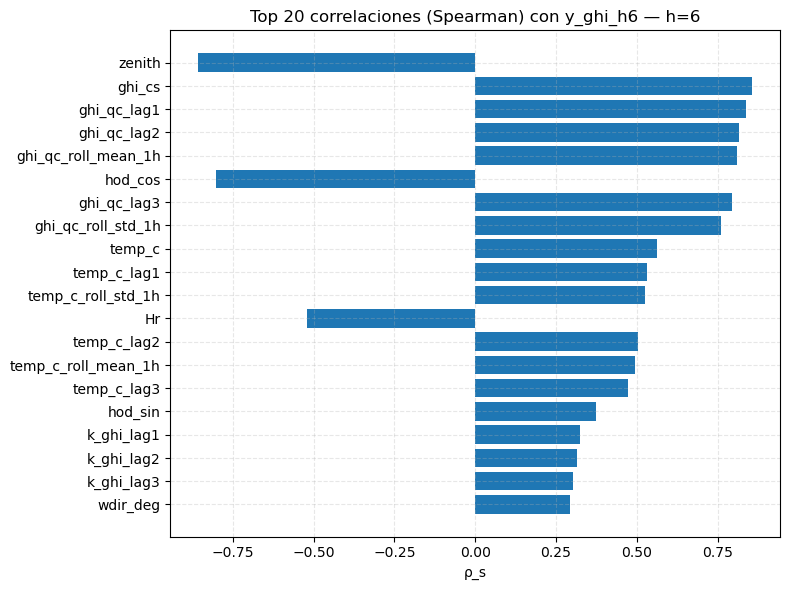


=== Procesando horizonte H=18 (=> +180 min) ===
  Usando TARGET: y_ghi_h18
  Filas tras limpieza: 82536 | #Features: 45 | Target: y_ghi_h18
  Guardado splits para y_ghi_h18 → h18
    train: (57775, 46) → ../data_processed/ground_train_h18.parquet
    val  : (12380, 46) → ../data_processed/ground_val_h18.parquet
    test : (12381, 46) → ../data_processed/ground_test_h18.parquet

  Top 10 features correlacionadas con y_ghi_h18 (Spearman):
hod_sin                0.720497
zenith                -0.571553
ghi_cs                 0.571290
hod_cos               -0.538504
ghi_qc_lag1            0.528124
ghi_qc_lag2            0.497819
ghi_qc_roll_mean_1h    0.489126
ghi_qc_lag3            0.466961
azimuth               -0.452022
ghi_qc_roll_std_1h     0.442796
Name: y_ghi_h18, dtype: float64


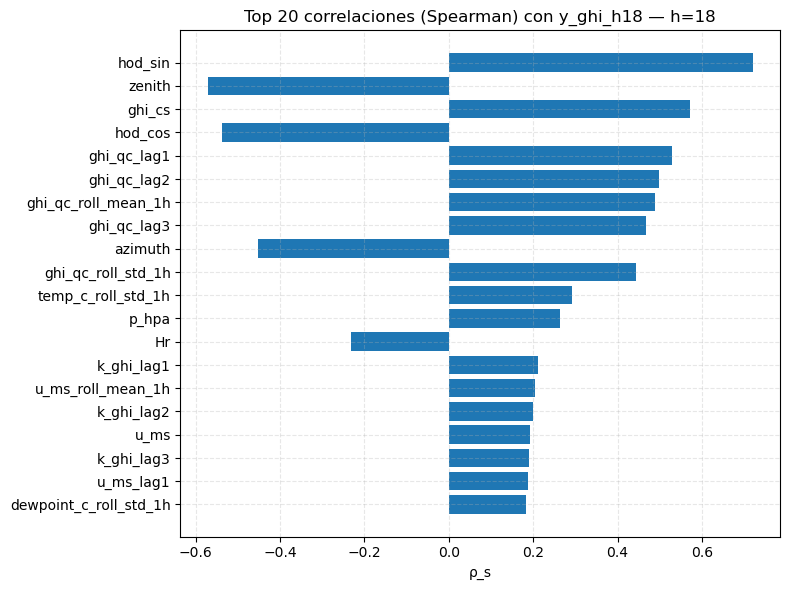


=== Procesando horizonte H=36 (=> +360 min) ===
  Usando TARGET: y_ghi_h36
  Filas tras limpieza: 82500 | #Features: 45 | Target: y_ghi_h36
  Guardado splits para y_ghi_h36 → h36
    train: (57749, 46) → ../data_processed/ground_train_h36.parquet
    val  : (12376, 46) → ../data_processed/ground_val_h36.parquet
    test : (12375, 46) → ../data_processed/ground_test_h36.parquet

  Top 10 features correlacionadas con y_ghi_h36 (Spearman):
hod_sin                0.860352
azimuth               -0.763848
temp_c_lag3           -0.466416
temp_c_roll_mean_1h   -0.456994
temp_c_lag2           -0.440331
temp_c_lag1           -0.413727
temp_c                -0.386488
v_ms_roll_std_1h      -0.234855
Hr                     0.221654
p_hpa                  0.218396
Name: y_ghi_h36, dtype: float64


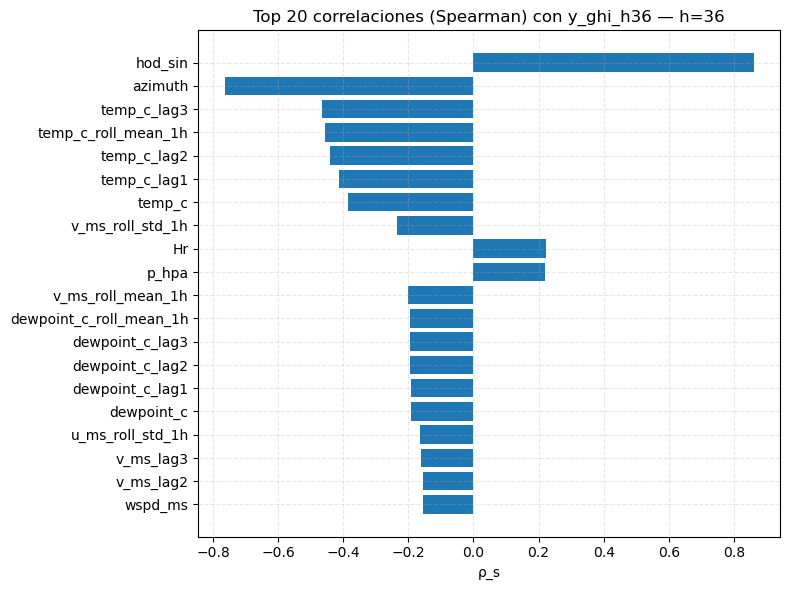

In [14]:
for H in H_LIST:
    print(f"\n==============================================")
    print(f"=== Procesando horizonte H={H} (=> +{H*10} min) ===")
    print(f"==============================================")

    # ---- Target detection para este horizonte ----
    candidatos = [f"y_ghi_h{H}", f"y_k_h{H}", f"y_ghi_sg_h{H}"]
    targets_existentes = [c for c in df.columns if c.startswith("y_")]

    TARGET = None
    # Preferencia: y_ghi_hH > y_k_hH > y_ghi_sg_hH
    for c in candidatos:
        if c in df.columns:
            TARGET = c
            break

    # Fallback: cualquier y_*_hH
    if TARGET is None:
        posibles_h = [c for c in targets_existentes if c.endswith(f"_h{H}")]
        if posibles_h:
            TARGET = posibles_h[0]

    if TARGET is None:
        print(f"  → No encontré ningún target y_* para h={H}, se omite.")
        continue

    print("  Usando TARGET:", TARGET)

    # ---- Features numéricas sin ningún y_* (evita fuga de info) ----
    all_numeric = df.select_dtypes(include=[np.number])
    y_cols = [c for c in all_numeric.columns if c.startswith("y_")]
    FEATS = [c for c in all_numeric.columns if c not in y_cols]

    # dataset Xy = Features + Target
    Xy = all_numeric[FEATS + [TARGET]].replace([np.inf, -np.inf], np.nan)
    Xy = Xy.dropna(subset=[TARGET])         # asegurar target
    Xy = Xy.dropna(how="any")               # filas completas 

    # columnas constantes
    const_cols = [c for c in FEATS if Xy[c].nunique(dropna=True) <= 1]
    if const_cols:
        Xy = Xy.drop(columns=const_cols)
        FEATS = [c for c in FEATS if c not in const_cols]
        print("  Quité columnas constantes:", const_cols)

    print(f"  Filas tras limpieza: {len(Xy)} | #Features: {len(FEATS)} | Target: {TARGET}")

    # ### Split 70/15/15 cronológico

    # %%
    n = len(Xy)
    i1 = int(n * 0.70)
    i2 = int(n * 0.85)
    train = Xy.iloc[:i1].copy()
    val   = Xy.iloc[i1:i2].copy()
    test  = Xy.iloc[i2:].copy()

    # Export splits específicos por horizonte
    train_out = OUT_PROC / f"ground_train_h{H}.parquet"
    val_out   = OUT_PROC / f"ground_val_h{H}.parquet"
    test_out  = OUT_PROC / f"ground_test_h{H}.parquet"

    train.to_parquet(train_out, engine="pyarrow", compression="zstd")
    val.to_parquet  (val_out,   engine="pyarrow", compression="zstd")
    test.to_parquet (test_out,  engine="pyarrow", compression="zstd")

    print(f"  Guardado splits para {TARGET} → h{H}")
    print("    train:", train.shape, "→", train_out)
    print("    val  :", val.shape,   "→", val_out)
    print("    test :", test.shape,  "→", test_out)


    # ### Sanity check

    # %%
    corrs = train[FEATS + [TARGET]].corr(
        method="spearman", numeric_only=True
    )[TARGET].drop(labels=[TARGET]).sort_values(key=np.abs, ascending=False)

    print(f"\n  Top 10 features correlacionadas con {TARGET} (Spearman):")
    print(corrs.head(10))

    # Plot 
    topN = min(20, len(corrs))
    plt.figure(figsize=(8, max(4, 0.3 * topN)))
    plt.barh(corrs.index[:topN][::-1], corrs.values[:topN][::-1])
    plt.title(f"Top {topN} correlaciones (Spearman) con {TARGET} — h={H}")
    plt.xlabel("ρ_s")
    plt.grid(True, ls="--", alpha=0.3)
    plt.tight_layout()
    plt.show()